<a href="https://colab.research.google.com/github/Hiroki-Kodama-PRS/Phantom-analysis/blob/main/Phantom_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# ===== 設定 =====
fs = 2000          # サンプリングレート [Hz]
window_sec = 1     # 窓の長さ [秒]

depths = [3, 9, 15, 21]
states = ["data1", "data2", "data3"]  # 実ファイル名に合わせて調整 (例: Normal, Ischaemia, Congestion)

records = []

# ===== データ読み込みと1秒ごとのAC/DC計算 =====
for depth in depths:
    for state in states:
        file = f"{depth}mm_adjusted_{state}.csv"
        df = pd.read_csv(file)
        for channel in ["ppgA_Red_raw", "ppgA_IR_raw"]:
            sig = df[channel].values
            step = fs * window_sec
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                ac = seg.max() - seg.min()     # 振幅（AC部分）
                mean_val = seg.mean()          # 平均値（DCの代表値）
                min_val = seg.min()            # 最小値（DCの代表値）
                records.append({
                    "Amplitude": ac,
                    "MeanValue": mean_val,
                    "MinValue": min_val,
                    "State": state,
                    "Depth": depth,
                    "Channel": "Red" if channel == "ppgA_Red_raw" else "IR"
                })

df_all = pd.DataFrame(records)

# ===== 正規化（各チャンネルのNormal=1基準） =====
# Normalをdata1と仮定しているので、必要に応じて置き換えてください
baseline = (
    df_all.query("State=='data1'")
    .groupby(["Channel", "Depth"])
    [["Amplitude","MeanValue","MinValue"]]
    .mean()
    .rename(columns={
        "Amplitude": "Amp_baseline",
        "MeanValue": "Mean_baseline",
        "MinValue": "Min_baseline"
    })
)

df_all = df_all.merge(
    baseline,
    on=["Channel", "Depth"],
    how="left"
)

df_all["Amp_norm"] = df_all["Amplitude"] / df_all["Amp_baseline"]
df_all["Mean_norm"] = df_all["MeanValue"] / df_all["Mean_baseline"]
df_all["Min_norm"] = df_all["MinValue"] / df_all["Min_baseline"]

# ===== 平均値テーブルを作成（状態×深さ×波長ごとの平均） =====
summary = (
    df_all
    .groupby(["Channel", "State", "Depth"])
    [["Amplitude","MeanValue","MinValue","Amp_norm","Mean_norm","Min_norm"]]
    .mean()
    .reset_index()
)

print("=== 各Channel×State×Depthの平均値 ===")
print(summary)

# ===== もしRed/IRそれぞれのNormalを1とした正規化テーブルをDepth×StateでPivot表示 =====
print("\n=== Amplitude normalized (Amp_norm) Pivot ===")
print(summary.pivot_table(index=["Channel","Depth"], columns="State", values="Amp_norm"))

print("\n=== MeanValue normalized (Mean_norm) Pivot ===")
print(summary.pivot_table(index=["Channel","Depth"], columns="State", values="Mean_norm"))

print("\n=== MinValue normalized (Min_norm) Pivot ===")
print(summary.pivot_table(index=["Channel","Depth"], columns="State", values="Min_norm"))


=== 各Channel×State×Depthの平均値 ===
   Channel  State  Depth  Amplitude  MeanValue  MinValue  Amp_norm  Mean_norm  \
0       IR  data1      3   0.006796   1.822378  1.818866  1.000000   1.000000   
1       IR  data1      9   0.004270   2.452707  2.450533  1.000000   1.000000   
2       IR  data1     15   0.002971   2.337707  2.336199  1.000000   1.000000   
3       IR  data1     21   0.002538   2.425896  2.424636  1.000000   1.000000   
4       IR  data2      3   0.005130   1.830351  1.827702  0.754839   1.004375   
5       IR  data2      9   0.003431   2.457375  2.455664  0.803594   1.001903   
6       IR  data2     15   0.002483   2.342253  2.341033  0.835793   1.001944   
7       IR  data2     21   0.002280   2.430329  2.429229  0.898488   1.001827   
8       IR  data3      3   0.005103   1.767454  1.764790  0.750806   0.969861   
9       IR  data3      9   0.004122   2.448920  2.446828  0.965340   0.998456   
10      IR  data3     15   0.002784   2.328764  2.327358  0.937269   0.99617

In [2]:
from scipy.signal import find_peaks

fs = 2000
signal = df[channel].values

# ピーク検出
peaks, _ = find_peaks(signal, prominence=0.001, distance=int(fs*0.3))

rise_times = []
fall_times = []
pulse_widths = []

for p in peaks:
    # ピークの前後で局所的な谷を探す
    # 例: ピーク±0.5秒の範囲で最小値を探す
    left = max(0, p - int(0.5*fs))
    right = min(len(signal), p + int(0.5*fs))
    seg = signal[left:right]
    # seg中の最大値=peak、最小値=baseline
    peak_idx = np.argmax(seg)
    trough_idx = np.argmin(seg[:peak_idx+1])  # 左側の谷
    next_trough_idx = peak_idx + np.argmin(seg[peak_idx:])  # 右側の谷

    if trough_idx < peak_idx < next_trough_idx:
        rise = (peak_idx - trough_idx)/fs
        fall = (next_trough_idx - peak_idx)/fs
        baseline = seg[trough_idx]
        peak_val = seg[peak_idx]
        half = baseline + 0.5*(peak_val - baseline)
        # 半値幅
        above = np.where(seg[trough_idx:next_trough_idx] >= half)[0]
        pw = (above[-1] - above[0])/fs if len(above)>1 else np.nan

        rise_times.append(rise)
        fall_times.append(fall)
        pulse_widths.append(pw)

# ===== 結果をDataFrameにまとめる =====
df_features = pd.DataFrame({
    "RiseTime_s": rise_times,
    "FallTime_s": fall_times,
    "PulseWidth_s": pulse_widths
})

print(df_features.describe())
df_features.to_csv("pulse_features.csv", index=False)

       RiseTime_s  FallTime_s  PulseWidth_s
count   81.000000   81.000000     81.000000
mean     0.252525    0.395259      0.641994
std      0.140641    0.223626      0.191951
min      0.006500    0.006000      0.136000
25%      0.167500    0.187000      0.513500
50%      0.229000    0.432000      0.658000
75%      0.349000    0.573000      0.797500
max      0.630000    0.794000      0.933000



=== ROC サマリ (新特徴含む, ブートストラップCIあり) ===
    Channel  Depth         Feature                     Pair    AUC  \
0       Red      3      RiseTime_s      Normal vs Ischaemia  0.470   
1       Red      3      RiseTime_s     Normal vs Congestion  0.487   
2       Red      3      RiseTime_s  Ischaemia vs Congestion  0.508   
3       Red      3      FallTime_s      Normal vs Ischaemia  0.533   
4       Red      3      FallTime_s     Normal vs Congestion  0.524   
..      ...    ...             ...                      ...    ...   
151      IR     21  RiseFall_ratio     Normal vs Congestion  0.424   
152      IR     21  RiseFall_ratio  Ischaemia vs Congestion  0.576   
153      IR     21    PW_amp_ratio      Normal vs Ischaemia  0.686   
154      IR     21    PW_amp_ratio     Normal vs Congestion  0.537   
155      IR     21    PW_amp_ratio  Ischaemia vs Congestion  0.351   

     AUC_bootstrap_mean  CI_lower  CI_upper  Cutoff  Sensitivity  Specificity  
0                 0.470     0.468     0.

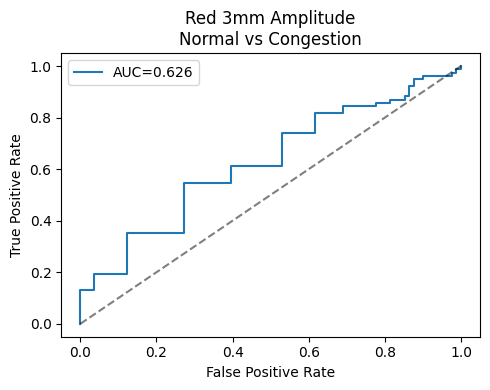

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ========= パラメータ設定 =========
fs = 2000  # サンプリング周波数
depths = [3,9,15,21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red","ppgA_IR_raw":"IR"}

# ========= 1. 拍動特徴抽出関数 =========
def extract_pulse_features(signal, fs=2000, prom=0.001, dist=0.3):
    peaks, _ = find_peaks(signal, prominence=prom, distance=int(fs*dist))
    features = []
    for p in peaks:
        left = max(0, p - int(0.5*fs))
        right = min(len(signal), p + int(0.5*fs))
        seg = signal[left:right]
        if len(seg)<5: continue
        peak_idx = np.argmax(seg)
        trough_idx = np.argmin(seg[:peak_idx+1])
        next_trough_idx = peak_idx + np.argmin(seg[peak_idx:])
        if trough_idx < peak_idx < next_trough_idx:
            rise = (peak_idx - trough_idx)/fs
            fall = (next_trough_idx - peak_idx)/fs
            baseline = seg[trough_idx]
            peak_val = seg[peak_idx]
            half = baseline + 0.5*(peak_val - baseline)
            above = np.where(seg[trough_idx:next_trough_idx] >= half)[0]
            pw = (above[-1] - above[0])/fs if len(above)>1 else np.nan
            amp = peak_val - baseline
            features.append((rise, fall, pw, amp))
    return features

# ========= 2. CSV読み込み＆特徴抽出 =========
records = []
for depth in depths:
    for state in state_map.keys():
        file = f"{depth}mm_adjusted_{state}.csv"
        df = pd.read_csv(file)
        for col,label in channels.items():
            feats = extract_pulse_features(df[col].values, fs)
            for r,f,pw,amp in feats:
                records.append({
                    "Depth": depth,
                    "State": state_map[state],
                    "Channel": label,
                    "RiseTime_s": r,
                    "FallTime_s": f,
                    "PulseWidth_s": pw,
                    "Amplitude": amp
                })

df_feat = pd.DataFrame(records)

# ========= 3. 複合指標を追加 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime_s"] / (df_feat["FallTime_s"]+1e-6)
df_feat["PW_amp_ratio"]   = df_feat["PulseWidth_s"] * df_feat["Amplitude"]

# Red と IR を結合して IR/Red 比を作成
# (同じDepth・State・インデックス近傍でマージする簡易的手法)
df_red = df_feat[df_feat.Channel=="Red"].reset_index()
df_ir  = df_feat[df_feat.Channel=="IR"].reset_index()
merged = pd.merge(df_red, df_ir, on=["Depth","State"], suffixes=("_Red","_IR"))
merged["IR_Red_amp_ratio"] = merged["Amplitude_IR"] / (merged["Amplitude_Red"]+1e-6)
# Redの行に対してIR/Redを追加（IRが無い場合はNaN）
df_feat = pd.merge(df_feat,
                   merged[["Depth","State","IR_Red_amp_ratio"]].drop_duplicates(),
                   on=["Depth","State"], how="left")

from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import pandas as pd

# ========= 4. ROC計算（ブートストラップCI付き） =========
pairs = [("Normal","Ischaemia"),("Normal","Congestion"),("Ischaemia","Congestion")]
features_to_eval = [
    "RiseTime_s","FallTime_s","PulseWidth_s",
    "Amplitude","RiseFall_ratio","PW_amp_ratio","IR_Red_amp_ratio"
]

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=1000, alpha=0.05):
    """AUCのブートストラップ95%CIを計算"""
    boot = []
    n = len(y_true)
    rng = np.random.default_rng(42)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)  # 置換つき再サンプリング
        if len(np.unique(y_true[idx])) < 2:
            continue
        boot.append(roc_auc_score(y_true[idx], y_score[idx]))
    if len(boot) == 0:
        return np.nan, np.nan, np.nan
    lower = np.percentile(boot, 2.5)
    upper = np.percentile(boot, 97.5)
    return np.mean(boot), lower, upper

results = []
for ch in ["Red","IR"]:
    for depth in depths:
        sub = df_feat[(df_feat.Channel==ch)&(df_feat.Depth==depth)]
        for feature in features_to_eval:
            if feature=="IR_Red_amp_ratio" and ch=="IR":
                continue
            # RedだけにIR/Red比を計算しているのでRed以外はスキップ
            for cls1,cls2 in pairs:
                df_sub = sub[sub.State.isin([cls1,cls2])]
                if len(df_sub)==0:
                    continue
                y_true = (df_sub.State==cls1).astype(int)
                y_score = df_sub[feature]
                if y_score.isna().any() or len(np.unique(y_true))<2:
                    continue
                try:
                    # 点推定と95%CI
                    auc_point = roc_auc_score(y_true, y_score)
                    auc_boot, ci_low, ci_up = bootstrap_auc_ci(y_true.values, y_score.values)

                    fpr,tpr,thr = roc_curve(y_true,y_score)
                    youden = tpr - fpr
                    idx = np.argmax(youden)

                    results.append({
                        "Channel":ch,
                        "Depth":depth,
                        "Feature":feature,
                        "Pair":f"{cls1} vs {cls2}",
                        "AUC":auc_point,
                        "AUC_bootstrap_mean": auc_boot,
                        "CI_lower": ci_low,
                        "CI_upper": ci_up,
                        "Cutoff":thr[idx],
                        "Sensitivity":tpr[idx],
                        "Specificity":1-fpr[idx]
                    })
                except Exception as e:
                    print(f"Error {ch} {depth} {feature} {cls1} vs {cls2}: {e}")

df_auc_feat = pd.DataFrame(results)
print("\n=== ROC サマリ (新特徴含む, ブートストラップCIあり) ===")
print(df_auc_feat.round(3))


# ========= 5. ROC 曲線プロット関数 =========
def plot_roc(df, ch, depth, feature, cls1, cls2):
    sub = df[(df.Channel==ch)&(df.Depth==depth)&(df.Pair==f"{cls1} vs {cls2}")&(df.Feature==feature)]
    if sub.empty:
        print("指定の組み合わせなし")
        return
    # 再計算
    data = df_feat[(df_feat.Channel==ch)&(df_feat.Depth==depth)&(df_feat.State.isin([cls1,cls2]))]
    y_true = (data.State==cls1).astype(int)
    y_score = data[feature]
    fpr,tpr,thr = roc_curve(y_true,y_score)
    auc = roc_auc_score(y_true,y_score)
    plt.figure(figsize=(5,4))
    plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{ch} {depth}mm {feature}\n{cls1} vs {cls2}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 例: Red 3mm でAmplitudeのROC
plot_roc(df_auc_feat, "Red", 3, "Amplitude", "Normal", "Congestion")

In [4]:
# === DataFrame全行をCSVに保存 ===
df_auc_feat.to_csv("ROC_summary_with_bootstrap.csv", index=False)

print("ROCサマリを 'ROC_summary_with_bootstrap.csv' として保存しました。")

ROCサマリを 'ROC_summary_with_bootstrap.csv' として保存しました。


Plotting ROC: IR 3mm Amplitude (Normal vs Congestion)


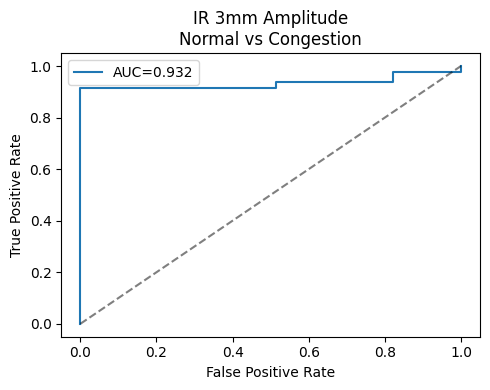

Plotting ROC: IR 3mm Amplitude (Normal vs Ischaemia)


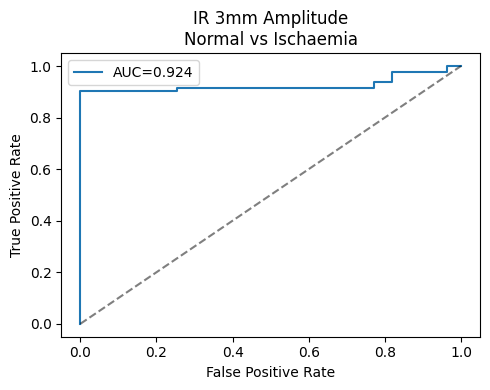

Plotting ROC: Red 3mm Amplitude (Normal vs Ischaemia)


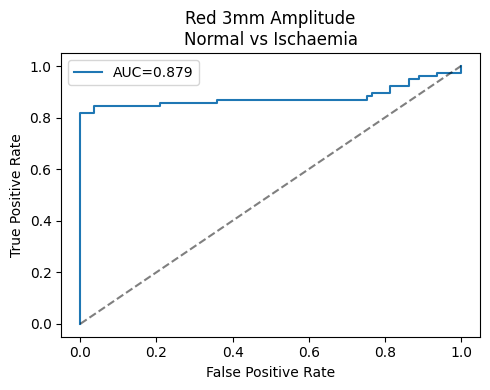

Plotting ROC: IR 9mm Amplitude (Normal vs Ischaemia)


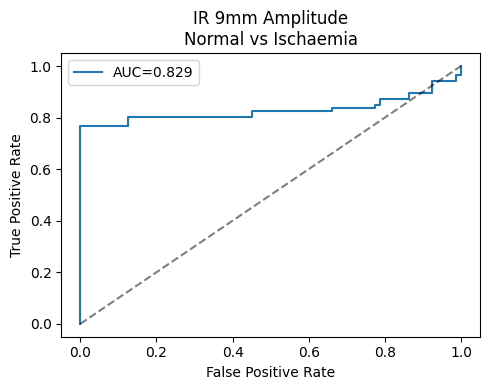

Plotting ROC: IR 15mm Amplitude (Normal vs Ischaemia)


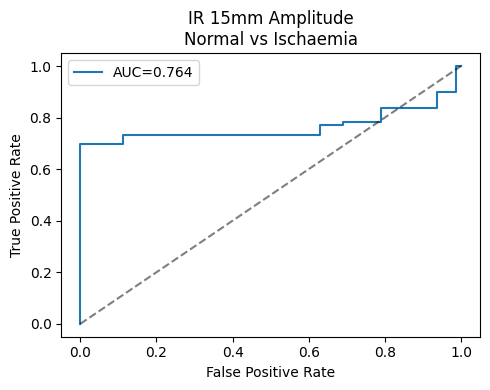

Plotting ROC: IR 9mm Amplitude (Normal vs Congestion)


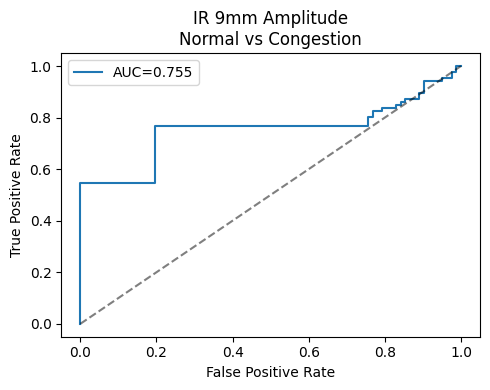

Plotting ROC: IR 15mm Amplitude (Normal vs Congestion)


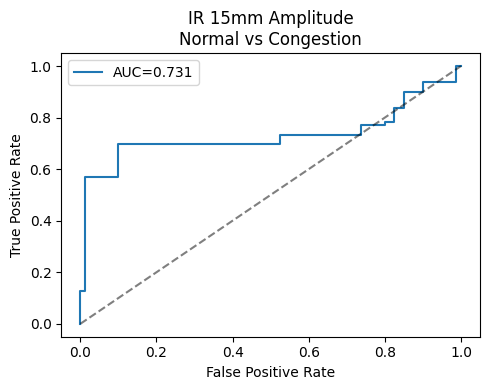

Plotting ROC: Red 3mm IR_Red_amp_ratio (Normal vs Congestion)


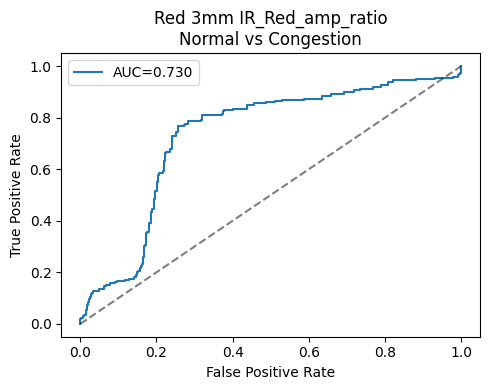

Plotting ROC: IR 3mm PW_amp_ratio (Normal vs Congestion)


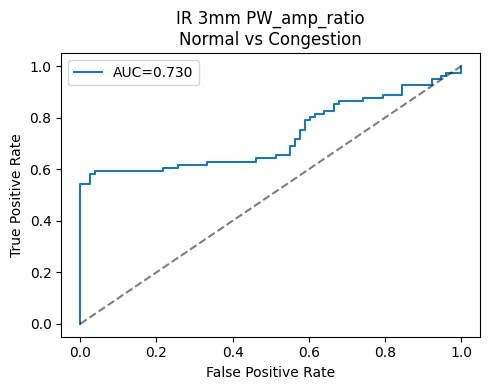

Plotting ROC: IR 3mm PW_amp_ratio (Normal vs Ischaemia)


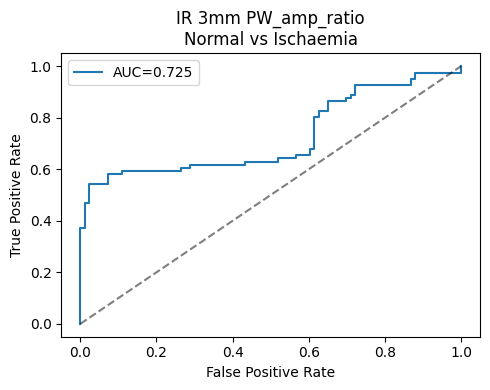

Plotting ROC: IR 21mm FallTime_s (Normal vs Ischaemia)


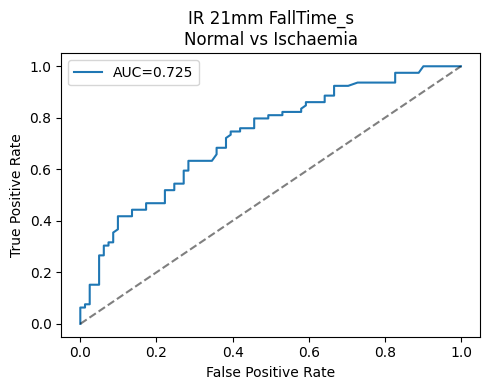

Plotting ROC: Red 9mm Amplitude (Normal vs Ischaemia)


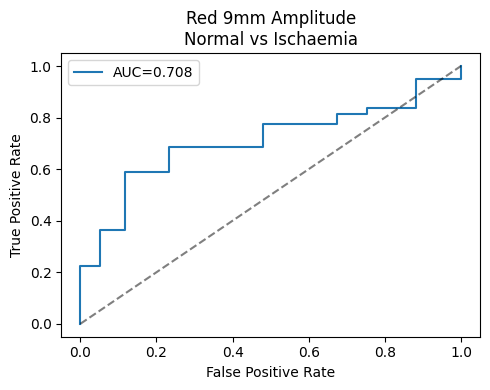

In [5]:
import pandas as pd

roc_list = [
    ("IR",3,"Amplitude","Normal","Congestion"),
    ("IR",3,"Amplitude","Normal","Ischaemia"),
    ("Red",3,"Amplitude","Normal","Ischaemia"),
    ("IR",9,"Amplitude","Normal","Ischaemia"),
    ("IR",15,"Amplitude","Normal","Ischaemia"),
    ("IR",9,"Amplitude","Normal","Congestion"),
    ("IR",15,"Amplitude","Normal","Congestion"),
    ("Red",3,"IR_Red_amp_ratio","Normal","Congestion"),
    ("IR",3,"PW_amp_ratio","Normal","Congestion"),
    ("IR",3,"PW_amp_ratio","Normal","Ischaemia"),
    ("IR",21,"FallTime_s","Normal","Ischaemia"),
    ("Red",9,"Amplitude","Normal","Ischaemia"),
]

# === 一括でROCプロット ===
for ch, depth, feature, cls1, cls2 in roc_list:
    print(f"Plotting ROC: {ch} {depth}mm {feature} ({cls1} vs {cls2})")
    plot_roc(df_auc_feat, ch, depth, feature, cls1, cls2)